# Notebook description

NEF relies on two abstractions: 
 - The signal is encoded in the rate of the neuron.
 - The dynamics of the neuron soma do not affect the dynamics of the computation.

This notebook is for examining whether NEF works with neurons that spike at low rates. In this case, I found that the dynamics of the soma begin to affect the dynamics of the computation.

# Setup

In [1]:
%matplotlib inline
import numpy as np
import nengo
from nengo.synapses import filt
from nengo.utils.ensemble import tuning_curves
from nengo.utils.matplotlib import rasterplot
from matplotlib import pyplot as plt

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [3]:
def spikes_to_decode(max_rate, tau, 
                     neuron_type=nengo.LIF(), plot=True, target_tau=None):
    """Utility for studying the relationship between spike rates, 
    filtering, and decode noise.
    
    Initializes the network with input x=0. Steps input to x=1.
        
    Parameters
    ----------
    max_rate : scalar
        maximum of rate distribution
    tau : scalar
        synaptic filter time constant
    neuron_type : nengo.LIF() or AdaptiveLIF()
        neuron model to use when building the Ensemble
    plot : boolean (optional)
        whether to make plots or not
    target_tau : float (optional)
        draw a target trajectory with this tau
    
    Returns
    -------
    total_spike_rate : float
        total spike rate of neurons
    mean_abs_decoder : float
        mean of absolute value of decoders
    ss_decode_var : float
        variance of the decode after it has settled to steady state
    rates : N-long array of floats
        theoretical spike rates for each neuron
    decoders : N-long array of floats
        decoders for each neuron
    """
    
    dt = .001
    T_init = 5./max_rate   # initialization time
    T_trans = 3*tau  # transient simulation time
    T = 10*tau + T_trans + T_init  # total simulation time
    
    x = 1.
    def in_fun(t):
        if t >= T_init:
            return x
        else:
            return 0.

    max_rates = nengo.dists.Uniform(0, max_rate)
    net = nengo.Network()
    with net:
        stim = nengo.Node(in_fun)
        out = nengo.Node(None, size_in=1)  # dummy Node to use as a connection target
        ens = nengo.Ensemble(200, 1, max_rates=max_rates, neuron_type=neuron_type)
        nengo.Connection(stim, ens, synapse=0.)
        conn = nengo.Connection(ens, out, synapse=0.)
        probe_d = nengo.Probe(ens, synapse=tau)  # probe the Ensemble's decoded output
        probe_s = nengo.Probe(ens.neurons, 'spikes')  # probe the spikes of the neurons
        probe_v = nengo.Probe(ens.neurons, 'voltage')
    # run simulation
    sim = nengo.Simulator(net, dt)
    sim.run(T, progress_bar=False)
    
    # extract data from simulation
    t = sim.trange()
    spikes = sim.data[probe_s]  # extract spike data
    encoders = sim.data[ens].encoders[:,0]
    decoders = sim.data[conn].decoders[0]  # extract decoders
    rate_dat = filt(spikes, tau, dt)  # filter spikes to estimate rates
    decode = np.dot(rate_dat, decoders)  # apply decoders to estimated rates to manually decode
    probed_decode = sim.data[probe_d]
    probed_voltage = sim.data[probe_v]
    
    T_clip = T_trans + T_init
    T_clip += T_init
    t0 = T_init

    idx = t>T_clip
    ss_spikes = spikes[idx, :]
    mean_spike_rates = np.mean(
        ss_spikes[:, encoders==1], axis=0)  # mean, nonzero spike rate
    total_spike_rate = np.sum(mean_spike_rates) # total 
    ss_decode_var = np.var(decode[idx])
    mean_abs_decoder = np.mean(np.abs(decoders))
    
    if plot:
        title_str = ('steady state decode variance = %f ' % (ss_decode_var) +
                     'mean absolute decode weight = %f ' % (mean_abs_decoder) +
                     'total spike rate = %.0f' % total_spike_rate)
        indices = np.argsort(encoders)
        filtered_step = np.zeros_like(t)
        filtered_step[t>=t0] = 1-np.exp(-(t[t>=t0]-t0)/tau)
        if target_tau is not None:
            target_trajectory = np.zeros_like(t)
            target_trajectory[t>=t0] = 1-np.exp(-(t[t>=t0]-t0)/target_tau)
        fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10,7), sharex=True)
        fig.subplots_adjust(top=.9, wspace=.2)
        rasterplot(t, spikes[:, indices], ax=axs[0,0])
        axs[0,0].set_ylabel('neuron index')
        axs[0,0].set_title('spike raster')
        axs[0,1].plot(t, rate_dat)
        axs[0,1].set_ylabel('estimated rates')
        axs[0,1].set_title('filtered spikes')
        axs[1,1].plot(t, probed_decode, 'b', lw=2, label='probed decode')
        axs[1,1].plot(t[1:], decode[:-1], 'r', label='decode from spike data')  # Note 1 dt offset
        axs[1,1].plot(t, filtered_step, 'g', label='filtered step')
        if target_tau is not None:
            axs[1,1].plot(t, target_trajectory, 'c', label='target trajectory')
        axs[1,1].legend(loc='lower right', fontsize=10)
        axs[1,1].set_ylabel('decoded value')
        axs[1,1].set_title('decodes')
        axs[1,1].set_xlabel(r'time (s)')
        axs[1,0].pcolormesh(t, np.arange(200), probed_voltage[:, indices].T, cmap='winter')
        axs[1,0].invert_yaxis()
        axs[1,0].set_title('voltage')
        axs[1,0].set_ylabel('neuron index')
        axs[1,0].set_xlabel('time (s)')
        fig.suptitle(title_str)
        for ax in axs.flat:
            ax.axvline(t0, c='r')
    gain = sim.data[ens].gain
    bias = sim.data[ens].bias
    rates = ens.neuron_type.rates(x*encoders, gain, bias)
    return total_spike_rate, mean_abs_decoder, ss_decode_var, rates, decoders

# Experimentation

First, we show what happens in the 'usual' case with LIF neurons that spike relatively quickly.

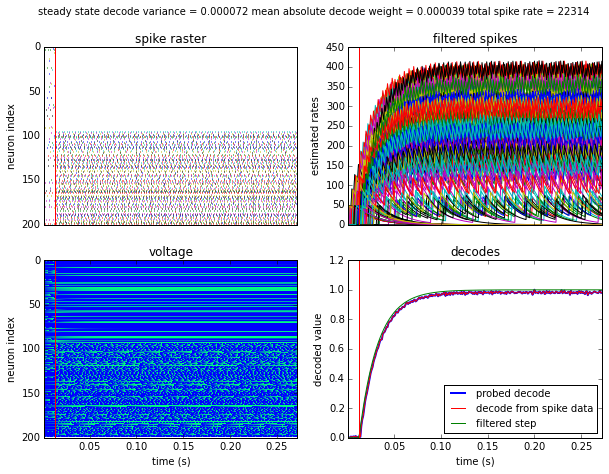

In [5]:
spikes_to_decode(400, .02);

Above, neurons are firing relatively. The filtered rates and decodes follow the saturating exponential trajectory that would be expected from filtering a step function.

Now, if we drop the spike rates, we'll see that the decode no longer follows the expected trajectory.

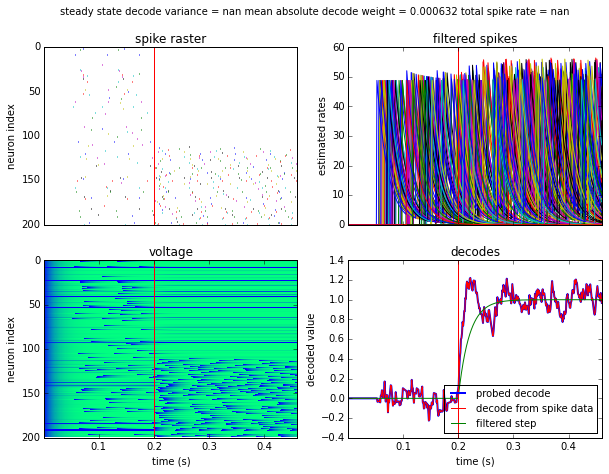

In [7]:
spikes_to_decode(25, .02);

With low rates, we can see that the voltages for slowly spiking neurons approach threhold slowly. When the input changes, all of these neurons all cross threshold and spike at similar times and cause the decode to overshoot the expected trajectory.

What about quadratic neurons?

In [ ]:
spikes_to_decode(25, .02, neuron_type=QIF());